# Nonlinear Elasticity in a multipatch domain


In [1]:
%pylab inline
import scipy
import itertools

from pyiga import bspline, assemble, vform, geometry, vis, solvers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# assemble matrix
from scipy.sparse import coo_matrix, block_diag, bmat
from scipy.sparse import bsr_matrix

# line search
from scipy.optimize import line_search

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
p = 3  # spline degree 
x_el= 40
y_el= 15
n_el = (x_el, y_el)  #(40,15)# number of elements in y/x direction, isotropic material
# displacement space: degree p,   continuity p-1
multi= 1
kvs_u = tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=multi) for n in n_el) # or : mult=2
m_u = tuple(kv.numdofs for kv in kvs_u)

In [3]:
# rubber, Lamé-coeff.
Mu = 3 # [GPa]
Lam = 0.28416 #  [GPa] (under ass. ny=0.48, almost incompressible)
# incompressible: Lam = 0


In [4]:
# define geometry
# realistic model of an artery: r_inner= 4mm, r_outer= 7mm (preprint)
# human carotid artery: r_i= 3.1 mm, r_o= 4mm (Holzapfel)
r_out = 4
r_in = 3.1

geos = [
 
    geometry.quarter_annulus(r1=r_in, r2=r_out),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(3*pi/2),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(pi),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(pi/2)
]

patches_u = [(kvs_u, g) for g in geos]

# Here we auto-detect the interfaces between the patches.
# It is also possible to join them manually using
# MP.join_boundaries(...) followed by MP.finalize().
MP_u = assemble.Multipatch(patches_u, automatch=True)

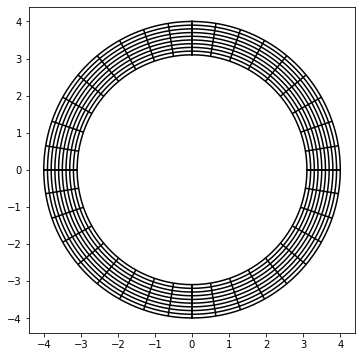

In [5]:
figsize(8,6)
for g in geos:
    vis.plot_geo(g)
axis('scaled');

In [6]:
class multipatch_block_handler:
    
    # Takes array of multi-patch objects
    def __init__( self, multi_patches ):
        self.multi_patches = multi_patches
        self.numpatches = multi_patches[0].numpatches
        for multi_patch in multi_patches:
            if multi_patch.numpatches != self.numpatches:
                print("Inconsistent numbers of patches")

    def patch_to_global(self, p):
        first = True
        for multi_patch in self.multi_patches:
            if first:
                X = multi_patch.patch_to_global(p)
                first = False
            else:
                X = scipy.sparse.block_diag((X,multi_patch.patch_to_global(p)))
        return X
    
    def compute_dirichlet_bcs(self, data):
        first = True
        p = 0
        offset = 0
        for multi_patch in self.multi_patches:
            data_p = []
            for item in data:
                #print(item[3])
                if len(item)<4 or p in item[3]:
                    data_p.append( (item[0], item[1], lambda *x : item[2](*x)[p]) )
            if len(data_p)>0:
                bcs_p = multi_patch.compute_dirichlet_bcs(data_p)
                #print('bcs_p', bcs_p)
                if first:
                    bcs = list(bcs_p)
                    first = False
                else:
                    #Indices need offset
                    bcs[0] = numpy.concatenate((bcs[0],bcs_p[0]+offset))
                    #Values are kept as-is
                    bcs[1] = numpy.concatenate((bcs[1],bcs_p[1]))
            offset += multi_patch.numdofs
            p += 1
        return tuple(bcs)
    
    def compute_local_offset_for_component(self, p, c):
        offset = 0
        for cc in range(c):
            dim = 1
            kvs, geo = self.multi_patches[cc].patches[p]
            for kv in kvs:
                dim *= kv.numdofs
            offset += dim
        return offset
    

In [7]:
# Multipatch objects for all variables
MP_block = multipatch_block_handler( [MP_u, MP_u] )

In [111]:
# source term f 
def f(x, y): return (0.0, 0.0)

#Neumann BC
#def gN(x, y): return (x, -y)  #outer pressure
def gN(x, y): 
    return (x/r_in*loading_value, y/r_in*loading_value)  #inner  pressure, normalized vector

#incremental loading
maxload = 2e-2# 8e-1 # 6e-2
nsteps= 5
loading= np.linspace(maxload/nsteps, maxload, nsteps)


# set loading_value (used in 1st iteration, lin. problem)
loading_value = loading[-1] # highest loading value
# set Neumann data
neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] 
# Robin boundary conditions
robin_data = neu_data


In [112]:
# define Dirichlet boundary function 
def g_zero(x, y): return (0.0, 0.0)

#def g_robin(x, y): return (0.1, 0.1) #?

# set up Dirichlet boundary conditions
bc = MP_block.compute_dirichlet_bcs([
    (1, 'right', g_zero ) 
])

rbm_data =  [(0, 'bottom'), (2, 'bottom' )] # eliminate dofs --Dirichlet bdc


In [113]:
def plot_grid(x, y, ax=None, **kwargs):
    """Plot a grid over a geometry"""
    ax = ax or plt.gca()
    segs1 = np.stack((x, y), axis=2)
    segs2 = segs1.transpose(1, 0, 2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

In [114]:
#split the solution into its components (displacement in x- and y- direction)
# visualization per patch
def get_defplot(u, patches_u, kvs_u):
    """Split solution vector into displacement components."""
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
   
    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]

    # evaluate displacement (and "pressure") over a grid in the parameter domain
    # grid variables
    ref = y_el # take number of elements in y-dir  #OR: set manually!
    xgrid = linspace(0, 1, ref)
    xygrid = (xgrid, xgrid)
    len_xgrid= len(xgrid)
    vrange= None
   
    figsize(10,10)
    fig, ax = plt.subplots()
    
    # visualization per patch
    for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches_u): #u_funcs 
        dis1 = u1_func.grid_eval(xygrid) #x-value
        dis2 = u2_func.grid_eval(xygrid) #y-value
        dis = np.stack((dis1,dis2), axis=-1)
        G = geo.grid_eval(xygrid)
        plot_grid(G[..., 0], G[..., 1], ax=ax, color="lightgrey")
        plot_grid(G[..., 0] + dis[..., 0], G[..., 1] + dis[..., 1], ax=ax, color="black")
        
        C = np.sqrt(np.power(dis[..., 0], 2) + np.power(dis[..., 1], 2))
        if vrange is None:
            vrange = (C.min(), C.max())
            
        plt.pcolormesh(G[..., 0] + dis[..., 0], G[..., 1] + dis[..., 1], C, shading='gouraud', cmap='summer', 
                                    vmin=vrange[0], vmax=vrange[1])
        #vis.plot_deformation(dis, ref, geo, ax, vmin=0.0, vmax=1.5e-3)
    colorbar();
    axis('equal')


In [115]:
# Compute solution of nonlinear elasticity problem

In [116]:
#split the solution into its components (displacement in x- and y- direction) and convert to BSpline function
def get_components(u, kvs_u):
    """Split solution vector into displacement components."""
    N = np.prod(tuple(kv.numdofs for kv in kvs_u))
    u1 = u[:N].reshape(m_u)          
    u2 = u[N:].reshape(m_u)    
    U = np.stack((u1,u2), axis=-1)
    return bspline.BSplineFunc(kvs_u, U)

In [117]:
def get_components_u(u, kvs_u):
    """Split solution vector into displacement components."""
    N = np.prod(tuple(kv.numdofs for kv in kvs_u))
    u1 = u[:N].reshape(m_u)          
    u2 = u[N:].reshape(m_u)    
    return np.stack((u1,u2), axis=-1)

In [118]:
# nonlinear variational form
def apply_nl(u_p, kvs_ux, geo_ux, X):
    dis = get_components(X.T @ u_p, kvs_ux)
    
    z_lam = Lam* assemble.assemble('div(dis)*div(v) * dx+ 1/2 *tr( grad(dis).T *grad(dis)) *div(v)*dx + inner(div(dis)*grad(dis), grad(v))*dx + inner(1/2 * tr(grad(dis).T *grad(dis))*grad(dis), grad(v)) *dx'
                             , kvs_ux, bfuns=[('v',2)], geo=geo_ux, dis=dis)
    z_mu = Mu* assemble.assemble('inner(grad(dis).T +grad(dis) + grad(dis).T *grad(dis), grad(v))*dx + inner(grad(dis)*(grad(dis).T +grad(dis) + grad(dis).T*grad(dis)), grad(v)) *dx'
                                    , kvs_ux, bfuns=[('v',2)], geo=geo_ux, dis=dis)
    return (z_lam + z_mu).ravel()  # vector z

# linearized variational form
def linearized(u_p, kvs_ux, geo_ux, X):
    dis = get_components(X.T @ u_p, kvs_ux)
    
    A_lin_lam = Lam* assemble.assemble('(inner( (div(dis) + 1/2 *tr( grad(dis).T *grad(dis) )) * grad(u), grad(v)) + div(u)*div(v) + tr( grad(dis).T *grad(u) ) * div(v) + inner( (div(u) + tr(grad(dis).T *grad(u)) ) * grad(dis), grad(v)) ) * dx'
                              , kvs_ux, bfuns=[('u',2), ('v',2)], geo=geo_ux, dis=dis) #matrix A_lam
    
    A_lin_mu = 2*Mu * assemble.assemble('(inner(1/2 * grad(u)*(grad(dis)+ grad(dis).T + grad(dis).T *grad(dis)) + (1/2) * (grad(u)+grad(u).T + grad(dis).T *grad(u) + grad(u).T *grad(dis)) + 1/2 * grad(dis)*(grad(u)+grad(u).T +grad(dis).T * grad(u)+ grad(u).T * grad(dis)), grad(v))) * dx'
                              , kvs_ux, bfuns=[('u',2), ('v',2)], geo=geo_ux, dis=dis) #matrix A_mu
    
    return A_lin_lam + A_lin_mu # matrix A


In [119]:
def rotate_normal(nv): # rotate
    nv_rot= []
    nx= nv[..., 0]
    ny= nv[..., 1]
    nv_rot= np.stack((ny,-nx), axis=-1)
    return nv_rot

In [120]:
# assemble matrix A and rhs b for nonlinear elasticity problem
# Neumann Problem 
def ass_nonlinsystem(u):
    first = True
    
    for p in range(MP_block.numpatches):
        X = MP_block.patch_to_global(p)
        
        # All the geometries are supposed to be equal; also kvs_ux and kvs_uy are equal
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p] #kvs_uy, geo_uy
        
        # The whole patch-local stiffness matrix
        A_p = linearized(u, kvs_ux, geo_ux, X) # take linearized variatonal form
        
        ### assemble mass matrix ####
        M_x = assemble.mass(kvs_ux, geo_ux)
        M_p = scipy.sparse.bmat(
            [[M_x, None,],
            [None, M_x]], format='csr')
    
        # RBM
        bR = assemble.inner_products(kvs_ux, f, f_physical=True, geo=geo_ux).ravel()
        for item in rbm_data:
            if item[0]==p:
                #print("p=", p)
                bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(2): #x and y 
                    #print("c=", c)
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    if p==2 and c==0: # exclude x-coord, fix y-coord
                        continue
                    bR[bdofs[y_el]+offset] += 1 # (43,1,2) # y-dir:15 elements, inner:bdofs[0]
                   

        # The patch-local Neumann boundary data, right-hand side
        b_p = assemble.inner_products(kvs_ux, f, f_physical=True, geo=geo_ux).ravel() - apply_nl(u, kvs_ux, geo_ux, X) # for arbitrary rhs
        uu = get_components_u(X.T @ u, kvs_ux)
        for item in neu_data:
            if item[0]==p:
                #N_e = assemble.assemble('inner(g,v)*ds', kvs_ux, bfuns=[('v',2)], geo=geo_ux, g=item[2], boundary=item[1]) #first attempt 
                #print('N_e', np.linalg.norm(N_e))
                ## implemented normal vector
                nv = assemble.assemble('inner(v, n) * ds', kvs_ux, bfuns=[('v', 2)], geo=geo_ux, boundary=item[1], layout='packed')
                nv_r = rotate_normal(nv)
                n_tilde = nv- rotate_normal(uu * nv_r)
                N_en= -n_tilde*loading_value
                #print('N_en=',N_en)
                #N_adapted = -n_tilde*loading_value
                #print('N_adapted', np.linalg.norm(N_adapted))
                
                # normal vector with loading
                #N_en2 = assemble.assemble('inner(n,v)*ds', kvs_ux, bfuns=[('v',2)], geo=geo_ux, boundary=item[1], layout='packed')
                #N_en2 *= -loading_value
                #print('N_en2=',N_en2)
                #print('N_en', np.linalg.norm(N_en))
                
                bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(2): #x and y 
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    for i in range(len(bdofs)):
                        b_p[bdofs[i]+offset] += N_en[i, 0, c] # (43,1,2)
        
        
        if first:
            A = X @ A_p @ X.T
            M = X @ M_p @ X.T
            b = X @ b_p 
            R = X @ bR
            first = False
        else:
            A += X @ A_p @ X.T
            M += X @ M_p @ X.T
            b += X @ b_p 
            R += X @ bR
            
    return A, M, b, R

In [121]:
# assemble matrix A and rhs b for nonlinear elasticity problem # Neumann force + Robin matrix
def ass_nonlinsystem_RN(u):
    first = True
    firstR = True
    
    for p in range(MP_block.numpatches):
        X = MP_block.patch_to_global(p)
        
        # All the geometries are supposed to be equal; also kvs_ux and kvs_uy are equal
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p] #kvs_uy, geo_uy
        
        # The whole patch-local stiffness matrix
        A_p = linearized(u, kvs_ux, geo_ux, X) # take linearized variatonal form
        
        ### assemble mass matrix ####
        M_x = assemble.mass(kvs_ux, geo_ux)
        M_p = scipy.sparse.bmat(
            [[M_x, None,],
            [None, M_x]], format='csr')
        
        # Robin-Data
        alpha, beta = 1.,1. # set factor
        #br_p = assemble.inner_products(kvs_ux, f, f_physical=True, geo=geo_ux).ravel()
        for item in robin_data:
            if item[0]==p:
                alpha= item[3] # set alpha, penalization
                #R_e = 1 /beta* assemble.assemble('inner(g_R,v) * ds', kvs_ux, bfuns=[('v', 2)], geo=geo_ux, g_R=item[2], boundary=item[1], layout='packed')
                AR_e = alpha/beta * assemble.assemble('u * v * ds', kvs_ux, bfuns=None, geo=geo_ux,
                                             format='csr', layout='blocked',boundary=item[1])
                bdofs_R = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(2): #x and y 
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    if firstR:
                        AR = X.tocsr()[:,bdofs_R+offset] @ AR_e @ X.tocsr()[:,bdofs_R+offset].T
                        firstR = False
                    else:
                        AR += X.tocsr()[:,bdofs_R+offset] @ AR_e @ X.tocsr()[:,bdofs_R+offset].T
                    
        
        # RBM
        bR = assemble.inner_products(kvs_ux, f, f_physical=True, geo=geo_ux).ravel()
        for item in rbm_data:
            if item[0]==p:
                #print("p=", p)
                bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(2): #x and y 
                    #print("c=", c)
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    if p==2 and c==0: # exclude x-coord, 
                        continue
                    bR[bdofs[y_el]+offset] += 1 # (43,1,2) # y-dir:15 elements, inner:bdofs[0]
                   

        # The patch-local Neumann boundary data, right-hand side
        b_p = assemble.inner_products(kvs_ux, f, f_physical=True, geo=geo_ux).ravel() - apply_nl(u, kvs_ux, geo_ux, X) # for arbitrary rhs
        uu = get_components_u(X.T @ u, kvs_ux)
        for item in neu_data:
            if item[0]==p:
                #N_e = assemble.assemble('inner(g,v)*ds', kvs_ux, bfuns=[('v',2)], geo=geo_ux, g=item[2], boundary=item[1]) #first attempt 
                #print('N_e', np.linalg.norm(N_e))
                
                ## implemented normal vector
                nv = assemble.assemble('inner(v, n) * ds', kvs_ux, bfuns=[('v', 2)], geo=geo_ux, boundary=item[1], layout='packed')
                nv_r = rotate_normal(nv)
                n_tilde = nv- rotate_normal(uu * nv_r)
                N_en= -n_tilde*loading_value
  
                # normal vector with loading
                #N_en2 = assemble.assemble('inner(n,v)*ds', kvs_ux, bfuns=[('v',2)], geo=geo_ux, boundary=item[1], layout='packed')
                #N_en2 *= -loading_value
                #print('N_en2=',N_en2)
                #print('N_en', np.linalg.norm(N_en))
                
                bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(2): #x and y 
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    for i in range(len(bdofs)):
                        b_p[bdofs[i]+offset] += N_en[i, 0, c] # (43,1,2)
        
        
        if first:
            A = X @ A_p @ X.T
            M = X @ M_p @ X.T
            b = X @ b_p 
            R = X @ bR
            first = False
        else:
            A += X @ A_p @ X.T
            M += X @ M_p @ X.T
            b += X @ b_p 
            R += X @ bR
            
    return A+AR, M, b, R

In [122]:
# elasticity problem
#linear problem = linearized problem (for development point x_0=(0...0) )
def grad_J(x): #nonlin function (rhs) # u
    u_p = x
    N_en =[]
    first = True
    for p in range(MP_block.numpatches): # go through each patch
        X = MP_block.patch_to_global(p)
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]
        uu = get_components_u(X.T @ u, kvs_ux)

        b_p = apply_nl(u_p, kvs_ux, geo_ux, X) #non-linear form a(u,v)
        #b0_p = assemble.inner_products(kvs_ux, f, f_physical=True, geo=geo_ux).ravel() # rhs (0,0,...,0) for nbc

        for item in neu_data:
            if item[0]==p:
                # normal vector with loading
                nv = -assemble.assemble('inner(v, n) * ds', kvs_ux, bfuns=[('v', 2)], geo=geo_ux, boundary=item[1], layout='packed')
                nv_r = rotate_normal(nv)
                n_tilde = nv - rotate_normal(uu * nv_r)
                N_en = -n_tilde*loading_value ## adapted normal
                
                #N_e   = assemble.assemble('inner(g,v)*ds', kvs_ux, bfuns=[('v',2)], geo=geo_ux, g=item[2], boundary=item[1]) # first attempt
                
                #N_en = -assemble.assemble('inner(n,v)*ds', kvs_ux, bfuns=[('v',2)], geo=geo_ux, boundary=item[1], layout='packed')
                #N_en *= -loading_value
                
                bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(2):
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    for i in range(len(bdofs)):
                        b_p[bdofs[i]+offset] += N_en[i, 0, c]
                        
                        
        if first:
            grad_b = X @ b_p 
            #grad_b = X @ (b_p- b0_p)
            first = False
        else:
            grad_b += X @ b_p 
            #grad_b += X @ (b_p- b0_p) 
            
    return grad_b


# define constant spline functions for integration
kvs_j = tuple(bspline.make_knots(0, 0.0, 1.0, n, mult=multi) for n in n_el) # constant basis vector for integration

def J(x): #energy functional
    u_p = x
    j_N = 0
    j = 0
    for p in range(MP_block.numpatches): # go through each patch
        X = MP_block.patch_to_global(p)
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]

        dis = get_components(X.T @ u_p, kvs_ux)
        j_lam = Lam/8 * assemble.assemble('tr( grad(dis).T *grad(dis) +grad(dis).T +grad(dis))**2 *v*dx'
                             , kvs_j, bfuns=[('v',1)], geo=geo_ux, dis=dis).ravel()
        j_mu = Mu/4 * assemble.assemble('tr((grad(dis).T *grad(dis) +grad(dis).T +grad(dis))*(grad(dis).T *grad(dis) +grad(dis).T +grad(dis))) *v*dx'
                                    , kvs_j, bfuns=[('v',1)], geo=geo_ux, dis=dis).ravel()
        j_p = sum(j_lam + j_mu)

        
        for item in neu_data:
            if item[0]==p:
                N_e = -assemble.assemble('inner(n, dis) *v * ds', kvs_j, bfuns=[('v',1)], geo=geo_ux, boundary=item[1], dis=dis)
                N_e *= loading_value
                #print('N_e1=', N_e1)
                #N_e  = assemble.assemble('inner(g,dis) *v *ds', kvs_j, bfuns=[('v',1)], geo=geo_ux, g=item[2], boundary=item[1], dis=dis) 
                #print('N_e=', N_e)
                j_N += N_e.sum()

        j += (j_p - j_N)
        
    return j


In [123]:
def Wolfe_LineSearch(f, f_grad, xk, pk):
    # Wolfe-Powell_Line search
    print('Start line search')
    
    mu1 = 0.01
    sigma = 0.9
    tau = 0.1
    tau1 = 0.3
    tau2 = 0.9
    gsi1 = 1
    gsi2 = 10
    
    def phi(alpha):
        return f(xk + alpha * pk)

    def derphi(alpha):
        return np.dot(f_grad(xk + alpha * pk), pk)
    
    alpha_L = 0
    alpha_R = None
    phi_L = phi(0)
    derphi_L = derphi(0)
    alphainf= True
    alpha =1 
    phi_min = -1.e2
    eps0 = 1.e-6
    max_iter = 5
    n_iter = 0
    
    while n_iter < max_iter:
        print("  {}. alpha between {} and {}".format(n_iter,alpha_L,alpha_R))
        n_iter +=1
        if alpha > 1: # alpha too big # alpha in(0,1)!
            #print('alpha >1')
            alpha_R = alpha
            alpha= alpha_L + tau1*(alpha_R - alpha_L)
        else:
            #print('a=', alpha)
            phi_hat= phi(alpha)
            if phi_hat < phi_min: # function unbounded to the bottom
                return alpha 

            if phi_hat > phi(0) + mu1*alpha*derphi(0): #alpha too big # 
                if derphi(0) >= 0:
                    print('  no descent direction')
                
                alphainf= False
                alpha_R = alpha
                delta = alpha_R - alpha_L
               # print('  delta=', delta)
                ## interpolation
                c = (phi_hat - phi_L - derphi_L*delta)/delta**2
                alpha_tilde = alpha_L - derphi_L/(2*c)
                alpha = min(max(alpha_L+ tau*delta, alpha_tilde), alpha_R - tau*delta)
                #print('alpha_int=', alpha)
            
            else: # alpha too small & not too big
                derphi_hat = derphi(alpha)
                if derphi_hat < sigma*derphi(0): # alpha too small
                    #print('  alpha too small')
                    if alphainf: # true, alpha_R =inf
                        #print('  alpha_R = inf')
                        if derphi_L/derphi_hat > (1+ gsi2)/gsi2:
                            alpha_tilde = alpha + (alpha - alpha_L)*max(derphi_hat/(derphi_L -derphi_hat), gsi1)
                        else:
                            alpha_tilde = alpha + gsi2*(alpha - alpha_L)
                    else: # alpha_R < inf
                        #print('  alpha_R < inf')
                        if derphi_L/derphi_hat > 1 + (alpha-alpha_L)/(tau2*(alpha_R -alpha)):
                            alpha_tilde = alpha + max((alpha-alpha_L)*derphi_hat/(derphi_L - derphi_hat), tau1*(alpha_R- alpha))
                        else:
                            alpha_tilde = alpha + tau2*(alpha_R - alpha)
                    ## update
                    alpha_L = alpha
                    phi_L = phi_hat
                    derphi_L = derphi_hat
                    alpha = alpha_tilde
                
                else:
                    return alpha

      

In [124]:
def Wolfe_LineSearch_st(f, f_grad, xk, pk, alpha_R=None):
    # Wolfe-Powell_Line search
    print('Start Wolfe line search')
    
    mu1 = 0.01
    sigma = 0.9
    tau = 0.1
    tau1 = 0.3
    tau2 = 0.9
    gsi1 = 1
    gsi2 = 10
    
    def phi(alpha):
        return f(xk + alpha * pk)

    def derphi(alpha):
        return np.dot(f_grad(xk + alpha * pk), pk)
    
    alpha_L = 0
    #alpha_R = 1 #None
    phi0 = phi(0)
    phi_L = phi0
    derphi0 = derphi(0)
    derphi_L = derphi0
    alpha = 1 
    phi_min = -1.e2
    
    eps0 = 1.e-6
    max_iter = 20
    n_iter = 0
    
    if derphi0 >= 0:
        print('  no descent direction: {}'.format(derphi_L))
        return None
    
    while n_iter < max_iter:
        print("  {}. alpha between {} and {}".format(n_iter,alpha_L,alpha_R))
        n_iter +=1

        phi_hat = phi(alpha)
        #if phi_hat < phi_min: # function unbounded to the bottom
        #    return alpha 

        print('     alpha = {} gives {}'.format(alpha,math.sqrt(phi_hat)))
        
        if phi_hat > phi0 + mu1*alpha*derphi0: # alpha too big
            print('     alpha too big')
            alpha_R = alpha
            delta = alpha_R - alpha_L
            ## interpolation
            c = (phi_hat - phi_L - derphi_L*delta)/delta**2
            alpha_tilde = alpha_L - derphi_L/(2*c)
            alpha = min(max(alpha_L + tau*delta, alpha_tilde), alpha_R - tau*delta)

        else: # alpha not too big
            derphi_hat = derphi(alpha)
            #print('     derphi_hat = {} and sigma*derphi(0) = {}'.format(derphi_hat,sigma*derphi(0)))
            if derphi_hat < sigma*derphi0: # alpha too small
                print('     alpha too small')
                if alpha_R != None and .6 * alpha_R < alpha:
                    print('     Interval small enough, so dont bother.')
                    return alpha
                if alpha_R == None: # alpha_R == inf
                    if derphi_L/derphi_hat > (1+ gsi2)/gsi2:
                        alpha_tilde = alpha + (alpha - alpha_L)*max(derphi_hat/(derphi_L -derphi_hat), gsi1)
                    else:
                        alpha_tilde = alpha + gsi2*(alpha - alpha_L)
                else: # alpha_R < inf
                    if derphi_L/derphi_hat > 1 + (alpha-alpha_L)/(tau2*(alpha_R -alpha)):
                        alpha_tilde = alpha + max((alpha-alpha_L)*derphi_hat/(derphi_L - derphi_hat), tau1*(alpha_R- alpha))
                    else:
                        alpha_tilde = alpha + tau2*(alpha_R - alpha)
                ## update
                alpha_L = alpha
                phi_L = phi_hat
                derphi_L = derphi_hat
                alpha = alpha_tilde
            else:
                print('     alpha neither too big, nor too small')
                return alpha

    return alpha

In [125]:
def Armijo(f, f_grad, xk, pk):
    # Amijo_Line search
    print('Start line search')
    
    mu1 = 0.01
    tau = 0.1 # 0.5
    
    def phi(alpha):
        return f(xk + alpha * pk)

    def derphi(alpha):
        return np.dot(f_grad(xk + alpha * pk), pk)
    
    alpha_L = 0
    alpha_R = None
    phi_L = phi(0)
    derphi0 = derphi(0)
    derphi_L = derphi(0)
    alphainf= True
    alpha =1 
    phi_min = -1.e2
    eps0 = 1.e-6
    max_iter = 5
    n_iter = 0
    
    if derphi(0) >= 0:
        print(' no descent direction ')
        return None
    

    while n_iter < max_iter:
        print("  {}. alpha between {} and {}".format(n_iter,alpha_L,alpha_R))
        n_iter +=1
        phi_hat= phi(alpha)
        derphi_hat = derphi(alpha)

        if phi_hat > phi(0) + mu1*alpha*derphi(0): #alpha too big #  

            alphainf= False
            alpha_R = alpha

            delta = alpha_R - alpha_L
            # print('  delta=', delta)
            ## interpolation
            c = (phi_hat - phi_L - derphi_L*delta)/delta**2
            alpha_tilde = alpha_L - derphi_L/(2*c)
            alpha = min(max(alpha_L+ tau*delta, alpha_tilde), alpha_R - tau*delta)
            print('alpha_int=', alpha)
            
        else:
            return alpha

In [126]:
def make_solver_orig(B, symmetric=False, spd=False):
    """Return a :class:`LinearOperator` that acts as a linear solver for the
    (dense or sparse) square matrix `B`.

    If `B` is symmetric, passing ``symmetric=True`` may try to take advantage of this.
    If `B` is symmetric and positive definite, pass ``spd=True``.
    """
    if spd:
        symmetric = True
# Gauß'sche Eliminationsverfahren - LU Zerlegung (auch LR für left-right)
    if scipy.sparse.issparse(B):
        print('use SuperLU')
            # use SuperLU (unless scipy uses UMFPACK?) -- really slow!
        spLU = scipy.sparse.linalg.splu(B.tocsc(), permc_spec='NATURAL')
        M= scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype, matvec=spLU.solve, matmat=spLU.solve)
        return M
# Cholesky Zerlegung: Matrix muss symmetrisch und positiv definit sein!                  
    else:
        if symmetric:
            print('use Cholesky')
            chol = scipy.linalg.cho_factor(B, check_finite=False)
            solve = lambda x: scipy.linalg.cho_solve(chol, x, check_finite=False)
            return scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype,
                    matvec=solve, matmat=solve)
        else:
            print('Matrix is not symmetric')
            LU = scipy.linalg.lu_factor(B, check_finite=False)
            solve = lambda x: scipy.linalg.lu_solve(LU, x, check_finite=False)
            return scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype,
                    matvec=solve, matmat=solve)

In [127]:
def make_solver(matrix):
    B= matrix.todense()
    """Return a :class:`LinearOperator` that acts as a linear solver for the
    (dense or sparse) square matrix `B`.

    If `B` is symmetric, passing ``symmetric=True`` may try to take advantage of this.
    If `B` is symmetric and positive definite, pass ``spd=True``.
    """
    
    chol = scipy.linalg.cho_factor(B, check_finite=False) # for s. p.d matrix
    solve = lambda x: scipy.linalg.cho_solve(chol, x, check_finite=False)
    return scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype, matvec=solve, matmat=solve)
       

In [128]:
def solve(matrix, vector):
    try:
        return make_solver(matrix).dot(vector)
    # cholesky --> takes spd matrix
    except LinAlgError:
        print('use Gradient direction') # matrix not positive definite
        return vector
        #return 10000*vector
        

In [129]:
def eliminate_dofs(R):
    bc1= np.nonzero(R)
    bc2 = np.zeros(shape(bc1))
    return ([bc1[0], bc2[0]])
    

In [130]:
# solve linearized system --Mixed problem (Neumann + Dirichlet)
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]

#initial value
u= np.zeros(dd)
solution= []

# set Neumann boundary force (via incremental loading) 

### Linear elasticity for largest loading
loading_value = loading[-1] # take last loading value
neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] # set neumann data

### first iteration ###
A, M, b, R = ass_nonlinsystem(u)

LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
rhs= LS.complete(LS.b)
r0= np.transpose(rhs).dot(M.dot(rhs)) #L2-norm
#r0= np.linalg.norm(LS.b) # rhs of undeformed system
print('r0=', r0)

u_d = make_solver_orig(LS.A).dot(LS.b) 
u_d = LS.complete(u_d)
u += u_d


A, M, b, R= ass_nonlinsystem(u)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
rhs= LS.complete(LS.b)
r= np.transpose(rhs).dot(M.dot(rhs)) #L2-norm
#r= np.linalg.norm(LS.b) # compute residuum
print('residual = ', r)

###-----------------###--------------------###
solution = [LS.restrict(u)]
# norm of delta u in first step
normed_du0= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
###----------------###---------------------###

r0= 9.627994268722374e-07
use SuperLU
residual =  2.053179658211682e-09


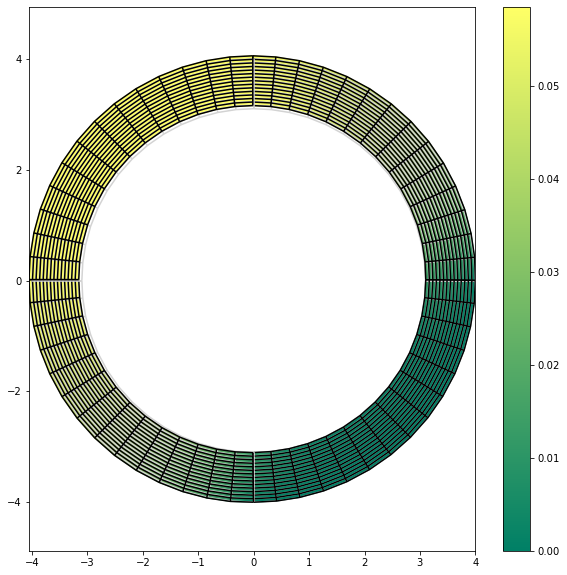

In [131]:
# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u)

Norm of rhs for max loading: 9.627994268722374e-07
Tolerance:                   9.627994268722374e-11
 
 
 1. loading: 0.004 

1
Residual = 3.8511977074889495e-08
use SuperLU
3.711999784891555e-05: Matrix is positive definite; use Newton direction.
grad_k * ud_k= -7.423999569783173e-05
Start Wolfe line search
  0. alpha between 0 and 1
     alpha = 1 gives 4.820322990147948e-05
     alpha neither too big, nor too small
alpha = 1
residual = 3.282984909667337e-12
 
 
 2. loading: 0.008 

1
Residual = 3.8631142971818327e-08
use SuperLU
3.723740131770949e-05: Matrix is positive definite; use Newton direction.
grad_k * ud_k= -7.44748026354216e-05
Start Wolfe line search
  0. alpha between 0 and 1
     alpha = 1 gives 7.577527025689595e-05
     alpha neither too big, nor too small
alpha = 1
residual = 6.942829625215427e-12
 
 
 3. loading: 0.012 

1
Residual = 3.8250264195431074e-08
use SuperLU
3.687161477808836e-05: Matrix is positive definite; use Newton direction.
grad_k * ud_k= -7.374322

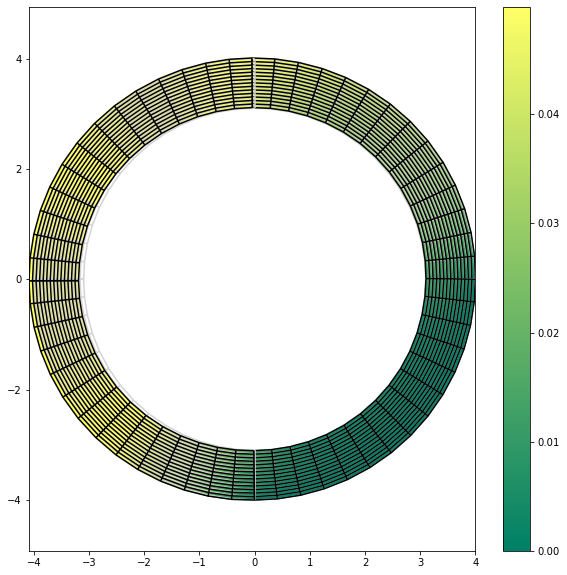

In [132]:
# solve linearized variational problem

#initial value
u= np.zeros(dd)

epsilon= 1e-4# 1e-5

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


### Linear elasticity for largest loading
loading_value = loading[-1] # take last loading value
neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] # set neumann data


A, M, b, R = ass_nonlinsystem(u)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
r0= np.transpose(LS.complete(LS.b)).dot(M.dot(LS.complete(LS.b))) #L2-norm
#r0 = np.linalg.norm(LS.b) # initial residual
print("Norm of rhs for max loading: {}".format(r0))
print("Tolerance:                   {}".format(r0*epsilon))
###


# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    loading_value = loading[t]
    neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] 

    count = 0
    rejected = False
    while True:
        count+=1
        print(count)

        # Assemble matrices and rhs in every iteration step
        if count == 1:
            A, M, b, R= ass_nonlinsystem(u)
            LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
            r= np.transpose(LS.complete(LS.b)).dot(M.dot(LS.complete(LS.b))) #L2-norm
            #r = np.linalg.norm(LS.b) # compute residuum
            print('Residual =',r)

        # # solve system # #
        u_d = make_solver_orig(LS.A).dot(LS.b)  #A+AR

        # check if matrix is positive definite in a particular direction u_d
        #sp = LS.b.dot(u_d)
        #sp = LS.b.dot(LS.A.T@u_d) # transpose A: AT* A*b ?
        sp = LS.b.dot(LS.A@u_d) # For the residual,...
        #if LS.b.dot(u_d) <= 0:
        if sp <= 0 or rejected: 
            print('{}: Matrix is not positive definite (or rejected); use gradient direction anyway!'.format(sp))
            u_d = LS.b
            rejected = False
        else:
            print('{}: Matrix is positive definite; use Newton direction.'.format(sp))
            
        # complete system dependent solution
        u_d = LS.complete(u_d)

        # # do Wolfe-Powell line search # # 
        alpha = None
        #alpha = Wolfe_LineSearch(J, grad_J, u, u_d) 
        
        def eval_norm(x):
            A, M, b, R = ass_nonlinsystem(x)
            LS = assemble.RestrictedLinearSystem(A, b, bc)
            #return np.transpose(LS.complete(LS.b)).dot(M.dot(LS.complete(LS.b))) **2 #L2-norm
            return np.linalg.norm(LS.b) ** 2
        def eval_norm_grad(x):
            A, M, b, R = ass_nonlinsystem(x)
            LS = assemble.RestrictedLinearSystem(A, b, bc)
            return LS.complete((-2) * LS.A.T @ LS.b)
        
        print( 'grad_k * ud_k=',  np.dot(eval_norm_grad(u), u_d))
       
        # Line-Search 
        alpha = Wolfe_LineSearch_st(eval_norm, eval_norm_grad, u, u_d, 1) 

        print('alpha =', alpha)
        if alpha != None:
            unew = u + alpha * u_d
            # compute new non-linear residuum
            A, M, b, R = ass_nonlinsystem(unew)
            LS = assemble.RestrictedLinearSystem(A, b, bc)
            rnew = np.transpose(LS.complete(LS.b)).dot(M.dot(LS.complete(LS.b))) #L2-norm
            #rnew = np.linalg.norm(LS.b)
            #if np.linalg.norm(LS.b) > r:
            if rnew > r:
                print("New residual would be {}. Reject this alpha!".format(rnew))
                alpha = None
        
        if alpha == None:           
            print('Use simple line search:')
            #u += 0.5 * u_d # alpha=0.5 (ignore line search)
            # Lets try to do gradient search
            alpha = 1.
            rnew = r+1
            while rnew > r and alpha > 1e-4:
                unew = u + alpha * u_d
                # compute new non-linear residuum
                A, M, b, R = ass_nonlinsystem(unew)
                LS = assemble.RestrictedLinearSystem(A, b, bc)
                rnew = np.transpose(LS.complete(LS.b)).dot(M.dot(LS.complete(LS.b))) #L2-norm
                #rnew = np.linalg.norm(LS.b) # compute residuum
                print('  alpha {} gives residual {}'.format(alpha,rnew))
                alpha /= 2
            if rnew > r:
                alpha = None
                print("alpha =", alpha)
                if rejected:
                    break # No way to continue !?
                else:
                    alpha = 0
                    rejected = True
            alpha *= 2 # double alpha
            if alpha >= 1:
                alpha = 2.
                rlast = rnew
                while alpha < 10000 and rnew <= rlast:
                    unew = u + alpha * u_d
                    # compute new non-linear residuum
                    A, M, b, R = ass_nonlinsystem(unew)
                    LS = assemble.RestrictedLinearSystem(A, b, bc)
                    rlast = rnew
                    rnew = np.transpose(LS.complete(LS.b)).dot(M.dot(LS.complete(LS.b))) #L2-norm
                    #rnew = np.linalg.norm(LS.b) # compute residuum
                    print('  alpha {} gives residual {}'.format(alpha,rnew))
                    alpha *= 2 # double alpha
                alpha /= 4 # quater alpha

            print("alpha =", alpha)            
            
        u += alpha * u_d            

        # compute new non-linear residuum
        A, M, b, R = ass_nonlinsystem(u)
        LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
        rold = r #?
        r = np.transpose(LS.complete(LS.b)).dot(M.dot(LS.complete(LS.b))) #L2-norm
        #r = np.linalg.norm(LS.b) # compute residuum
        print('residual =', r)

        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = alpha * normed_du # times alpha
        stepsizes.append(stepsize_du)
        #---------------------------------------------------#

        if r < epsilon * r0: # break condition
            break
        elif count == 30:
            break
            
    ud_array.append(u_d) 
    solutions.append(LS.restrict(u))
    iter_counts.append(count)
        
# print deformation plot
get_defplot(u, patches_u, kvs_u)

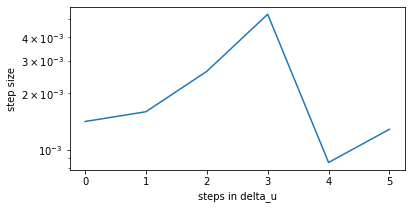

In [133]:
# plot history of step sizes
figsize(6,3)
fig, ax = plt.subplots()
yscale('log')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(stepsizes);
xlabel('steps in delta_u'); ylabel('step size');

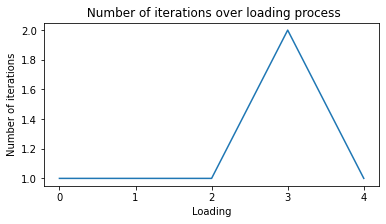

In [134]:
figsize(6,3)
fig, ax= plt.subplots()

s_cts= shape(iter_counts)[0]
plot(range(s_cts), iter_counts)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title(' Number of iterations over loading process');
xlabel('Loading'); ylabel('Number of iterations');

Norm of rhs for max loading: 9.627994268722374e-07
Tolerance:                   9.627994268722374e-11
 
 
 1. loading: 0.004 

Residual= 3.8511977074889495e-08
1
use SuperLU
3.711999784891555e-05: Matrix is positive definite; use Newton direction.
grad_k*p_k= -0.0005158796217234655
Start line search
  0. alpha between 0 and None
alpha= 1
residual =  3.282984909667337e-12
 
 
 2. loading: 0.008 

Residual= 3.8631142971818327e-08
1
use SuperLU
3.723740131770949e-05: Matrix is positive definite; use Newton direction.
grad_k*p_k= -0.0005136084301008748
Start line search
  0. alpha between 0 and None
alpha= 1
residual =  6.942829625215427e-12
 
 
 3. loading: 0.012 

Residual= 3.8250264195431074e-08
1
use SuperLU
3.687161477808836e-05: Matrix is positive definite; use Newton direction.
grad_k*p_k= -0.0005075432785378335
Start line search
  0. alpha between 0 and None
alpha= 1
residual =  2.411013960018986e-11
 
 
 4. loading: 0.016 

Residual= 3.714444287071004e-08
1
use SuperLU
3.581211478

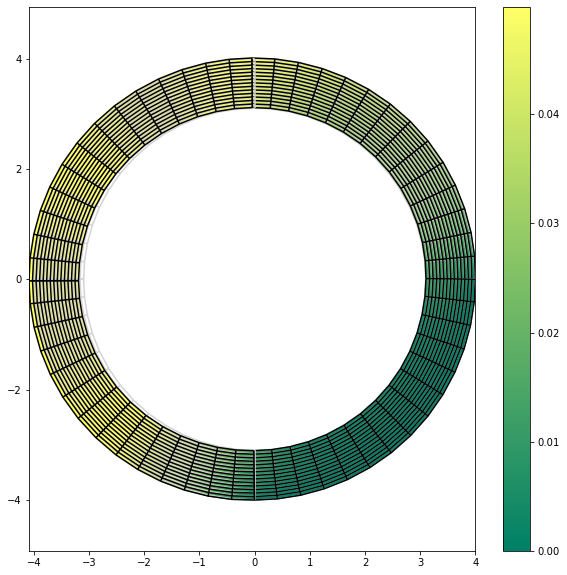

In [135]:
 #solve nonlinear system
#initial value
u= np.zeros(dd)

solutions= []
stepsizes =[] 
ud_array = []
iter_counts = []

epsilon= 1e-4 #1e-6

### Linear elasticity for largest loading
loading_value = loading[-1]# take last loading value
neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] # set neumann data
A, M, b, R = ass_nonlinsystem(u)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
rhs= LS.complete(LS.b)
r0= np.transpose(rhs).dot(M.dot(rhs)) #L2-norm
#r0 = np.linalg.norm(LS.b) # initial residual
print("Norm of rhs for max loading: {}".format(r0))
print("Tolerance:                   {}".format(r0*epsilon))
###


# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    loading_value = loading[t]
    neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] 
    
    # first residuum
    A, M, b, R= ass_nonlinsystem(u)
    LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
    rhs= LS.complete(LS.b)
    r= np.transpose(rhs).dot(M.dot(rhs)) #L2-norm
    #r1= np.linalg.norm(LS.b) # rhs of undeformed system
    print('Residual=', r)

    count= 0
    rejected = False
    
    while True:
        count+=1
        print(count)

        # Assemble matrices and rhs in every iteration step
        A, M, b, R= ass_nonlinsystem(u)
        LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system

        # # solve system # #
        #u_d= solvers.make_solver(LS.A).dot(LS.b)
        u_d = make_solver_orig(LS.A).dot(LS.b) 
        
        sp = LS.b.dot(LS.A@u_d) # For the residual,...
        #if LS.b.dot(u_d) <= 0:
        if sp <= 0 or rejected: 
            print('{}: Matrix is not positive definite (or rejected); use gradient direction anyway!'.format(sp))
            u_d = LS.b
            rejected = False
        else:
            print('{}: Matrix is positive definite; use Newton direction.'.format(sp))
            

        # complete system dependent solution
        u_d = LS.complete(u_d)
        
        print( 'grad_k*p_k=',  np.dot(grad_J(u), u_d))

        # # do Wolfe-Powell line search # # 
        #alpha= Wolfe_LineSearch(J, grad_J, u, u_d) 
        alpha= Armijo(J, grad_J, u, u_d) 
        #alpha= line_search(J, grad_J, u, u_d) # use integrated line search (scipy)
        print('alpha=', alpha)
        
        if alpha != None:
            unew = u + alpha * u_d
            # compute new non-linear residuum
            A, M, b, R = ass_nonlinsystem(unew)
            LS = assemble.RestrictedLinearSystem(A, b, bc)
            rhs= LS.complete(LS.b)
            rnew = np.transpose(rhs).dot(M.dot(rhs)) #L2-norm
            #rnew = np.linalg.norm(LS.b)
            if rnew > r:
                print("New residual would be {}. Reject this alpha!".format(rnew))
                alpha = None
        
        if alpha == None:           
            print('Use simple line search:')
            #u += 0.5 * u_d # alpha=0.5 (ignore line search)
            # Lets try to do gradient search
            alpha = 1.
            rnew = r+1
            while rnew > r and alpha > 1e-4:
                unew = u + alpha * u_d
                # compute new non-linear residuum
                A, M, b, R = ass_nonlinsystem(unew)
                LS = assemble.RestrictedLinearSystem(A, b, bc)
                rhs= LS.complete(LS.b)
                rnew = np.transpose(rhs).dot(M.dot(rhs)) #L2-norm
                #rnew = np.linalg.norm(LS.b) # compute residuum
                print('  alpha {} gives residual {}'.format(alpha,rnew))
                alpha /= 2
            if rnew > r:
                alpha = None
                print("alpha =", alpha)
                if rejected:
                    break # No way to continue !?
                else:
                    alpha = 0
                    rejected = True
            alpha *= 2 # double alpha
            if alpha >= 1:
                alpha = 2.
                rlast = rnew
                while alpha < 10000 and rnew <= rlast:
                    unew = u + alpha * u_d
                    # compute new non-linear residuum
                    A, M, b, R = ass_nonlinsystem(unew)
                    LS = assemble.RestrictedLinearSystem(A, b, bc)
                    rlast = rnew
                    rhs= LS.complete(LS.b)
                    rnew = np.transpose(rhs).dot(M.dot(rhs)) #L2-norm
                    #rnew = np.linalg.norm(LS.b) # compute residuum
                    print('  alpha {} gives residual {}'.format(alpha,rnew))
                    alpha *= 2 # double alpha
                alpha /= 4 # quater alpha

            print("alpha =", alpha)            
            
        u += alpha * u_d            

            
        # compute new non-linear residuum
        A, M, b, R = ass_nonlinsystem(u)
        
        LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
        rhs= LS.complete(LS.b)
        r = np.transpose(rhs).dot(M.dot(rhs)) #L2-norm
        #r = np.linalg.norm(LS.b) # compute residuum
        print('residual = ', r)

        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = alpha * normed_du # times alpha
        #stepsize_du = abs(normed_du0-normed_du)
        stepsizes.append(stepsize_du)
        #---------------------------------------------------#

        if r < epsilon* r0: # break condition # r < epsilon* r1:
            break
        elif count == 30:
            break
  
    ud_array.append(u_d) 
    solutions.append(LS.restrict(u))
    iter_counts.append(count)
        
# print deformation plot
get_defplot(u, patches_u, kvs_u)

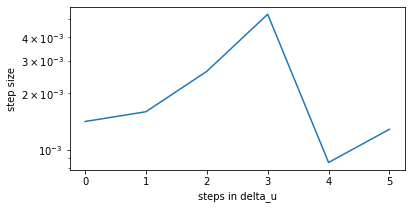

In [136]:
# plot history of step sizes
figsize(6,3)
fig, ax = plt.subplots()
yscale('log')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(stepsizes);
xlabel('steps in delta_u'); ylabel('step size');

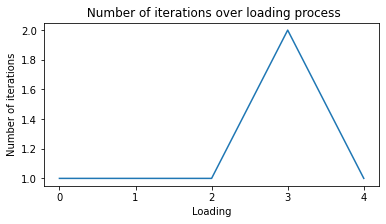

In [137]:
figsize(6,3)
fig, ax= plt.subplots()

s_cts= shape(iter_counts)[0]
plot(range(s_cts), iter_counts)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title(' Number of iterations over loading process');
xlabel('Loading'); ylabel('Number of iterations');

In [138]:
# solve linearized system -- Neumann problem - 3 dofs
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]

#initial value
u= np.zeros(dd)
solution= []

# set Neumann boundary force (via incremental loading) 

### Linear elasticity for largest loading
loading_value = loading[-1] # take last loading value
neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] # set neumann data

### first iteration ###
A, M, b, R = ass_nonlinsystem(u)
bcc= eliminate_dofs(R) # eliminate 3dofs

LS = assemble.RestrictedLinearSystem(A, b, bcc) # solve linearized system
rhs= LS.complete(LS.b)
r0= np.transpose(rhs).dot(M.dot(rhs)) #L2-norm
print('r0=', r0)

u_d = make_solver_orig(LS.A).dot(LS.b) 
u_d = LS.complete(u_d)
u += u_d


A, M, b, R= ass_nonlinsystem(u)
bcc= eliminate_dofs(R)

LS = assemble.RestrictedLinearSystem(A, b, bcc) # solve linearized system
rhs= LS.complete(LS.b)
r= np.transpose(rhs).dot(M.dot(rhs)) #L2-norm
print('residual = ', r)

###-----------------###--------------------###
sol = [u]
solution = [LS.restrict(u)]
# norm of delta u in first step
normed_du0= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
###----------------###---------------------###

r0= 9.627994268722374e-07
use SuperLU
residual =  2.0842193298588013e-09


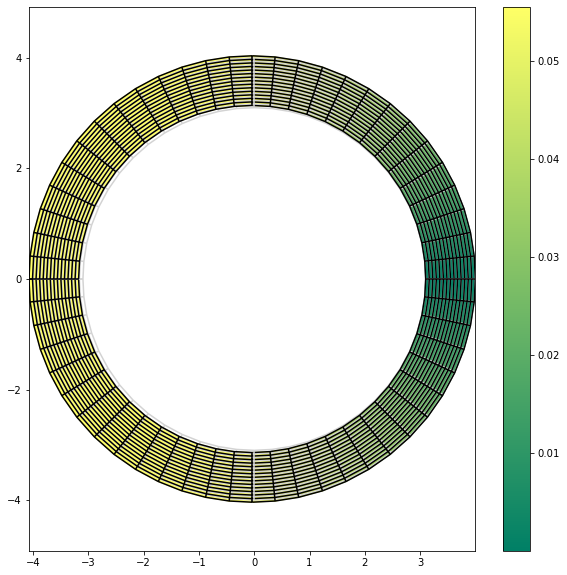

In [139]:
# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u)

In [140]:
def get_defplotP(u, patches_u, kvs_u):
    """Split solution vector into displacement components."""
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
    
    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]

    # evaluate displacement (and "pressure") over a grid in the parameter domain
    # grid variables
    ref = y_el # take number of elements in y-dir  #OR: set manually!
    xgrid = linspace(0, 1, ref)
    xygrid = (xgrid, xgrid)
    len_xgrid= len(xgrid)
    vrange= None
   
    figsize(7,7)
    fig, ax = plt.subplots()
    ###
    
    max_xval_i = 0
    max_yval_i = 0
    max_rad_i = 0
    max_rad_o = 0
    idx_ri = 0
    idx_ro = 0
    count=0
    # visualization per patch
    for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches_u): #u_funcs 
        print('\n patch:', count)
        dis1 = u1_func.grid_eval(xygrid) #x-value
        dis2 = u2_func.grid_eval(xygrid) #y-value
        dis = np.stack((dis1,dis2), axis=-1)
       
        G = geo.grid_eval(xygrid)
        x_val_i=[]
        y_val_i=[]
        x_val_o=[]
        y_val_o=[]
        
        #print('x_o=', G[8,y_el-1, 0]+dis1[8, y_el-1])
        #print('y_o=', G[8,y_el-1, 1]+dis2[8,y_el-1])
        #print('x_i=', G[8,0, 0]+dis1[8, 0])
        #print('y_i=', G[8,0, 1]+dis2[8,0])
        #print('inner radius:',np.sqrt( (G[8,0, 0]+dis1[8, 0])**2 + (G[8,0, 1]+dis2[8,0])**2))
        #print('outer radius:',np.sqrt((G[8,y_el-1, 0]+dis1[8, y_el-1])**2 + (G[8,y_el-1, 1]+dis2[8,y_el-1])**2))

        for i in range(len(dis)):
            x_val_i = np.append(x_val_i, G[i,0,0]+ dis1[i,0])
            y_val_i = np.append(y_val_i, G[i,0,1]+dis2[i,0])

            x_val_o = np.append(x_val_o, G[i,y_el-1,0]+ dis1[i,y_el-1])
            y_val_o = np.append(y_val_o, G[i,y_el-1,1]+ dis2[i,y_el-1])

        max_xval_ip = max(abs(x_val_i))
        print('inner radius x:',max_xval_ip)
        idx_xi = np.argmax(abs(x_val_i))
        print('idx:', idx_xi)
        if max_xval_i <= max_xval_ip:
                max_xval_i = max_xval_ip
                idx_i = idx_xi
                idcs_xi = (count, idx_i)

        max_xval_op = max(abs(x_val_o))
        print('outer radius x:', max_xval_op)
        idx_xo = np.argmax(abs(x_val_o))
        print('idx:',idx_xo)


        max_yval_ip = max(abs(y_val_i))
        print('inner radius y:',max_yval_ip)
        idx_yi = np.argmax(abs(y_val_i))
        print('idx:',idx_yi)
        if max_yval_i <= max_yval_ip:
                max_yval_i = max_yval_ip
                idx_i = idx_yi
                idcs_yi = (count, idx_i)

        max_yval_op = max(abs(y_val_o))
        print('outer radius y:', max_yval_op)
        idx_yo = np.argmax(abs(y_val_o))
        print('idx:',idx_yo)
        
        radius_inner= np.sqrt(max_xval_ip**2 + (G[idx_xi,0,1]+dis2[idx_xi,0])**2) # take index 'idx_xi' everywhere
        radius_outer= np.sqrt((G[idx_xi,y_el-1,0]+dis1[idx_xi,y_el-1])**2 + (G[idx_xi,y_el-1,1]+dis2[idx_xi,y_el-1])**2)
        
        print( '\n inner radius:', radius_inner)
        print( ' outer radius:', radius_outer)
        
        if max_rad_i <= radius_inner:
            max_rad_i = radius_inner
            idx_ri = count
            
        if max_rad_o <= radius_outer:
            max_rad_o = radius_outer
            idx_ro = count
        
        print (' ratio:', radius_inner/radius_outer) # with respect to max. inner radius coord.
        count+=1
        
        plot(G[idx_yi, 0, 0] + dis1[idx_yi, 0], G[idx_yi, 0, 1] + dis2[idx_yi, 0], 'mo') # inner radius y
        plot(G[idx_xi, 0, 0] + dis1[idx_xi, 0], G[idx_xi, 0, 1] + dis2[idx_xi, 0], 'ro') # inner radius x
        plot(G[idx_yo, 14, 0] + dis1[idx_yo, y_el-1], G[idx_yo, y_el-1, 1] + dis2[idx_yo, y_el-1], 'co') # outer radius y
        plot(G[idx_xo, 14, 0] + dis1[idx_xo, y_el-1], G[idx_xo, y_el-1, 1] + dis2[idx_xo, y_el-1], 'bo') # outer radius x

        C = np.sqrt(np.power(dis[..., 0], 2) + np.power(dis[..., 1], 2))
        if vrange is None:
            vrange = (C.min(), C.max())
            
        plt.pcolormesh(G[..., 0] + dis[..., 0], G[..., 1] + dis[..., 1], C, shading='gouraud', cmap='viridis', 
                                    vmin=vrange[0], vmax=vrange[1])
        #vis.plot_deformation(dis, ref, geo, ax, vmin=0.0, vmax=1.5e-3)
    colorbar();
    axis('equal')

    print('\n max_val_xi:', max_xval_i)
    print('(patch, index):', idcs_xi)

    print('\n max_val_yi:', max_yval_i)
    print('(patch, index):', idcs_yi)

    print('\n max_radius_i:', max_rad_i)
    print(' patch:', idx_ri)
    print('\n max_radius_o:', max_rad_o)
    print(' patch:', idx_ro)
    


In [141]:
def get_defplotPP(u, patches_u, kvs_u):
    """Split solution vector into displacement components."""
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
    
    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]

    # evaluate displacement (and "pressure") over a grid in the parameter domain
    # grid variables
    ref = y_el # take number of elements in y-dir  #OR: set manually!
    xgrid = linspace(0, 1, ref)
    xygrid = (xgrid, xgrid)
    len_xgrid= len(xgrid)
    vrange= None
   
    figsize(7,7)
    fig, ax = plt.subplots()
    ###
    
    max_xval_i = 0
    max_yval_i = 0
    max_rad_i = 0
    max_rad_o = 0
    idx_ri = 0
    idx_ro = 0
    count=0
    # visualization per patch
    for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches_u): #u_funcs 
        print('\n patch:', count)
        dis1 = u1_func.grid_eval(xygrid) #x-value
        dis2 = u2_func.grid_eval(xygrid) #y-value
        dis = np.stack((dis1,dis2), axis=-1)
       
        G = geo.grid_eval(xygrid)
        x_val_i=[]
        y_val_i=[]
        x_val_o=[]
        y_val_o=[]
        
        i= 0
        
    
        radius_inner = np.sqrt( (G[i,0, 0]+dis1[i, 0])**2 + (G[i,0, 1]+dis2[i,0])**2)
        radius_outer = np.sqrt((G[i,y_el-1, 0]+dis1[i, y_el-1])**2 + (G[i,y_el-1, 1]+dis2[i,y_el-1])**2)
        print('inner radius_{}= {}'.format(i, radius_inner))
        print('outer radius_{}= {}'.format(i, radius_outer))
        
        print (' ratio:', radius_inner/radius_outer) # with respect to max. inner radius coord.
        
        plot(G[i, 0, 0] + dis1[i, 0], G[i, 0, 1] + dis2[i, 0], 'ro') # inner radius
        plot(G[i, y_el-1, 0] + dis1[i, y_el-1], G[i, y_el-1, 1] + dis2[i, y_el-1], 'bo') # outer radius

        
        i= 8
        radius_inner = np.sqrt( (G[i,0, 0]+dis1[i, 0])**2 + (G[i,0, 1]+dis2[i,0])**2)
        radius_outer = np.sqrt((G[i,y_el-1, 0]+dis1[i, y_el-1])**2 + (G[i,y_el-1, 1]+dis2[i,y_el-1])**2)
        print('inner radius_{}= {}'.format(i, radius_inner))
        print('outer radius_{}= {}'.format(i, radius_outer))
        
        print (' ratio:', radius_inner/radius_outer, '\t') # with respect to max. inner radius coord.
        
        plot(G[i, 0, 0] + dis1[i, 0], G[i, 0, 1] + dis2[i, 0], 'mo') # inner radius 
        plot(G[i, y_el-1, 0] + dis1[i, y_el-1], G[i, y_el-1, 1] + dis2[i, y_el-1], 'co') # outer radius

        

        count+=1
       
        C = np.sqrt(np.power(dis[..., 0], 2) + np.power(dis[..., 1], 2))
        if vrange is None:
            vrange = (C.min(), C.max())
            
        plt.pcolormesh(G[..., 0] + dis[..., 0], G[..., 1] + dis[..., 1], C, shading='gouraud', cmap='viridis', 
                                    vmin=vrange[0], vmax=vrange[1])
        #vis.plot_deformation(dis, ref, geo, ax, vmin=0.0, vmax=1.5e-3)
    colorbar();
    axis('equal')


In [152]:
maxload = 3e-1 #5e-1 # 6e-2
nsteps= 3
loading= np.linspace(maxload/nsteps, maxload, nsteps)


In [153]:
# solve linearized system 
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]

#initial value
u= np.zeros(dd)
solution= []
sol=[]

# set Neumann boundary force (via incremental loading) 

### Linear elasticity for largest loading
loading_value = loading[-1] # take last loading value
neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] # set neumann data

### first iteration ###
A, M, b, R = ass_nonlinsystem(u)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
rhs= LS.complete(LS.b)
r0= np.transpose(rhs).dot(M.dot(rhs)) #L2-norm
#r0= np.linalg.norm(LS.b) # rhs of undeformed system
print('r0=', r0)

u_d = make_solver_orig(LS.A).dot(LS.b) 
u_d = LS.complete(u_d)
u += u_d


A, M, b, R= ass_nonlinsystem(u)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
rhs= LS.complete(LS.b)
r= np.transpose(rhs).dot(M.dot(rhs)) #L2-norm
#r= np.linalg.norm(LS.b) # compute residuum
print('residual = ', r)

###-----------------###--------------------###
sol = [u]
solution = [LS.restrict(u)]
# norm of delta u in first step
normed_du0= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
#normed_du0= np.linalg.norm(u_d)
###----------------###---------------------###

r0= 0.00021662987104625336
use SuperLU
residual =  0.00010751831285752352


In [154]:
def get_defplotR(u, patches_u, kvs_u, R):
    """Split solution vector into displacement components."""
    u= u*R*50 # fixed points
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
    
    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]

    # evaluate displacement (and "pressure") over a grid in the parameter domain
    # grid variables
    ref = n_el[1] # take number of elements in y-dir  #OR: set manually!
    xgrid = linspace(0, 1, ref)
    xygrid = (xgrid, xgrid)
    len_xgrid= len(xgrid)
    vrange= None
   
    figsize(7,7)
    fig, ax = plt.subplots()
    
    # visualization per patch
    for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches_u): #u_funcs 
        dis1 = u1_func.grid_eval(xygrid) #x-value
        dis2 = u2_func.grid_eval(xygrid) #y-value
        dis = np.stack((dis1,dis2), axis=-1)
       
        G = geo.grid_eval(xygrid)
        #plot_grid(G[..., 0], G[..., 1], ax=ax, color="lightgrey")
        #plot_grid(G[..., 0] + dis[..., 0], G[..., 1] + dis[..., 1], ax=ax, color="black")
        plot(G[8,0, 0]+dis1[8,0],G[8,0, 1]+dis2[8,0], 'ro') # inner
        #plot(G[0,0, 0]+dis[0, 0, 0],G[0,0, 1]+dis[0,0,1], 'ro') # inner radius
        plot(G[0,14, 0]+dis1[0, 14],G[0,14, 1]+dis2[0,14], 'bo') # outer radius
        plot(G[8,14, 0]+dis1[8, 14],G[8,14, 1]+dis2[8,14], 'bo')



        C = np.sqrt(np.power(dis[..., 0], 2) + np.power(dis[..., 1], 2))
        if vrange is None:
            vrange = (C.min(), C.max())
            
        plt.pcolormesh(G[..., 0] + dis[..., 0], G[..., 1] + dis[..., 1], C, shading='gouraud', cmap='summer', 
                                    vmin=vrange[0], vmax=vrange[1])
        vis.plot_deformation(dis, ref, geo, ax, vmin=0.0, vmax=1.5e-3)
    colorbar();
    axis('equal')
    


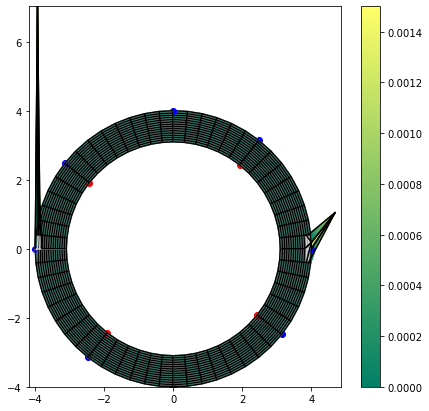

In [155]:
get_defplotR(u, patches_u, kvs_u, R)

In [144]:
# set up and solve linear system
#LS = assemble_st.RestrictedLinearSystem(A + AR, rhs + N + R, dir_bcs)
# rhs: Neumann-vector + Robin-vector
# A: A + Robin-matrix

In [156]:
alpha = 1e-0
robin_data = [(1, 'right', g_zero, alpha)] # instead of Dirichlet-bdc, outer bd fixed

r0= 0.00021662987104625336
use SuperLU
residual =  0.00013027871787709062


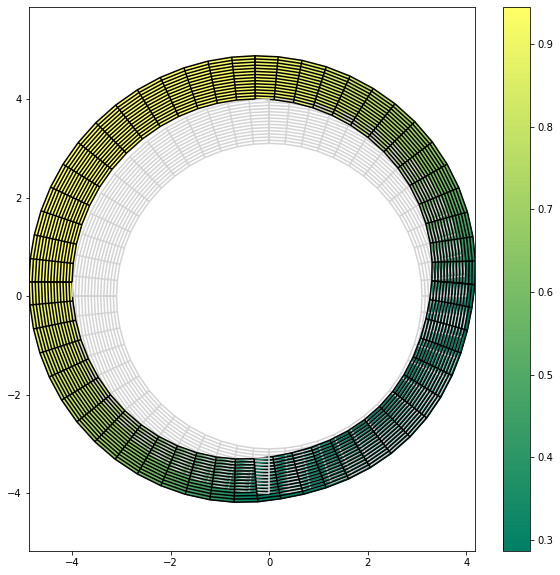

In [157]:
# solve linearized system #Robin instead of Dirichlet, + Neumann force (inner pressure)
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]

#initial value
u= np.zeros(dd)
solution= []

# set Neumann boundary force (via incremental loading) 

### Linear elasticity for largest loading
loading_value = loading[-1] # take last loading value
neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] # set neumann/robin data

### first iteration ###
A, M, b, R = ass_nonlinsystem_RN(u)
r0= np.transpose(b).dot(M.dot(b)) #L2-norm
print('r0=', r0)

u_d = make_solver_orig(A).dot(b) 
u += u_d

A, M, b, R = ass_nonlinsystem_RN(u)
rhs= b
r= np.transpose(b).dot(M.dot(b)) #L2-norm
print('residual = ', r)

###-----------------###--------------------###
#solution = [u]
solution = [LS.restrict(u)]
# norm of delta u in first step
normed_du0= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
###----------------###---------------------###

# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u)

In [158]:
#get_defplotP(u, patches_u, kvs_u)


 patch: 0
inner radius_0= 3.313192490500083
outer radius_0= 4.1781841538857805
 ratio: 0.7929742607009697
inner radius_8= 3.792703427786359
outer radius_8= 4.662015636378123
 ratio: 0.8135329702010342 	

 patch: 1
inner radius_0= 3.313192490500657
outer radius_0= 4.178184153886292
 ratio: 0.7929742607010098
inner radius_8= 3.1648167780332264
outer radius_8= 4.038028888812708
 ratio: 0.7837528817095141 	

 patch: 2
inner radius_0= 4.011719857347541
outer radius_0= 4.884911680871081
 ratio: 0.821247162575551
inner radius_8= 3.6843342564469785
outer radius_8= 4.551936895422722
 ratio: 0.809399238410318 	

 patch: 3
inner radius_0= 4.011719857344927
outer radius_0= 4.884911680868461
 ratio: 0.8212471625754564
inner radius_8= 4.098946587700357
outer radius_8= 4.973494798997844
 ratio: 0.8241582133606115 	


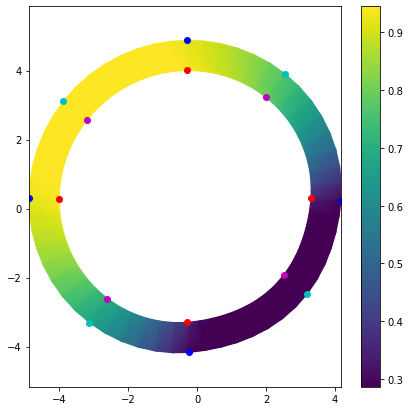

In [159]:
get_defplotPP(u, patches_u, kvs_u)

In [160]:
loading

array([0.1, 0.2, 0.3])

In [220]:
u

array([0.23378334, 0.23265855, 0.23050484, ..., 0.34994798, 0.35006947,
       0.35013064])

In [221]:
stress_vec=[]

ref = y_el # take number of elements in y-dir  #OR: set manually!
xgrid = linspace(0, 1, ref)
xygrid = (xgrid, xgrid)
len_xgrid= len(xgrid)

N = np.prod(tuple(kv.numdofs for kv in kvs_u))

for p in range(MP_block.numpatches):
    X = MP_block.patch_to_global(p)
    kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p] #kvs_uy, geo_uy
    stress= apply_nl(u, kvs_ux, geo_ux, X)
    print('nonlinear stress in patch {} gives {}'.format(p, stress))
    stress_vec.append(stress)
    
   
    s1 = stress[:N].reshape(m_u)          
    s2 = stress[N:].reshape(m_u)    
    S = np.stack((s1,s2), axis=-1)
    S_spl = bspline.BSplineFunc(kvs_u, S)
   # print( S_spl.grid_eval(xygrid))
    #print( S_spl.grid_eval(r_out, 0))
    
    
   
    # restrict solution to each individual patch - BSpline functions
   # s1_func = geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ s1)
    #s2_func = geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ s2)
          
   # st1 = s1_func.grid_eval(xygrid) #x-value
    #st2 = s2_func.grid_eval(xygrid) #y-value
    #st = np.stack((st1,st2), axis=-1)


nonlinear stress in patch 0 gives [7.41403668e-03 3.53007118e-05 7.81284704e-06 ... 1.77400033e-06
 2.15617613e-06 1.09753102e-04]
nonlinear stress in patch 1 gives [-0.02331546 -0.04597507 -0.06776097 ...  0.05238687  0.03509421
  0.01662931]
nonlinear stress in patch 2 gives [-7.41128510e-03 -5.77260559e-05 -7.52163911e-05 ... -3.99085613e-04
 -3.41635467e-04 -2.03754353e-04]
nonlinear stress in patch 3 gives [ 0.02354598  0.04649725  0.06852464 ... -0.05092196 -0.03356785
 -0.01660497]


In [222]:
print(shape(u))

(6048,)


In [223]:
shape(u_d)

(6048,)

In [224]:
shape(stress_vec)

(4, 1548)

In [122]:
# S  = F*P = (I + Grad(u))*(Lam * tr(E)*I + 2*Mu*E))
# E= 1/2 * (Grad(u).T + Grad(u) + Grad(u).T * Grad(u))
# S* (1, 0) # first component
# S*n #in normal direction

In [51]:
# calculate Strain 
# Sigma * n
# colorbar w.r.t. strain, comparison ngsolve